1. Does scaling the data help for univariate/multivariate data? (e.g. getting all of the values between 0 & 1)
  * Try doing this for a univariate model (e.g. model_1) and a multivariate model (e.g. model_6) and see if it effects model training or evaluation results.

2. Get the most up to date data on Bitcoin, train a model & see how it goes (our data goes up to May 18 2021).
  * You can download the Bitcoin historical data for free from coindesk.com/price/bitcoin and clicking “Export Data” -> “CSV”.

3. For most of our models we used WINDOW_SIZE=7, but is there a better window size?
  * Setup a series of experiments to find whether or not there’s a better window size.
  * For example, you might train 10 different models with HORIZON=1 but with window sizes ranging from 2-12.

4. Create a windowed dataset just like the ones we used for model_1 using `tf.
keras.preprocessing.timeseries_dataset_from_array()` and retrain `model_1` using the recreated dataset.

5. For our multivariate modelling experiment, we added the Bitcoin block reward size as an extra feature to make our time series multivariate.
  * Are there any other features you think you could add?
  * If so, try it out, how do these affect the model?


6. Make prediction intervals for future forecasts. To do so, one way would be to train an ensemble model on all of the data, make future forecasts with it and calculate the prediction intervals of the ensemble just like we did for model_8.


7. For future predictions, try to make a prediction, retrain a model on the predictions, make a prediction, retrain a model, make a prediction, retrain a model, make a prediction (retrain a model each time a new prediction is made). Plot the results, how do they look compared to the future predictions where a model wasn’t retrained for every forecast (model_9)?


8. Throughout this notebook, we’ve only tried algorithms we’ve handcrafted ourselves. But it’s worth seeing how a purpose built forecasting algorithm goes.

  * Try out one of the extra algorithms listed in the modelling experiments part such as:

    * Facebook’s Kats library - there are many models in here, remember the
    
    * machine learning practioner’s motto: experiment, experiment, experiment.
LinkedIn’s Greykite library

In [5]:
!pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

# Get Data

In [6]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2025-02-13 12:38:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2025-02-13 12:38:33 (7.32 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [7]:
# Import with pandas
import pandas as pd
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # Parse the date column and tell pandas column 1 is a datetime

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [8]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [9]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [10]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction

In [11]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [12]:
import tensorflow as tf
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


In [13]:
import numpy as np

In [14]:
window_step = np.expand_dims(np.arange(WINDOW_SIZE+HORIZON), axis=0)
window_step

array([[0, 1, 2, 3, 4, 5, 6, 7]])

In [15]:
window_step + np.expand_dims(np.arange(len(prices) - (WINDOW_SIZE+HORIZON-1)), axis=1 )

array([[   0,    1,    2, ...,    5,    6,    7],
       [   1,    2,    3, ...,    6,    7,    8],
       [   2,    3,    4, ...,    7,    8,    9],
       ...,
       [2777, 2778, 2779, ..., 2782, 2783, 2784],
       [2778, 2779, 2780, ..., 2783, 2784, 2785],
       [2779, 2780, 2781, ..., 2784, 2785, 2786]])

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [17]:
# Create function to view NumPy arrays as windows
def make_windows_scaled(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array into a 2D array of sequential labelled windows of window_size horizon size labels
    """
    # Scale the data
    scaler.fit(np.expand_dims(x, axis=1))
    scaled_x = scaler.transform(np.expand_dims(x, axis=1))
    scaled_x = np.squeeze(scaled_x)

    # 1. Create a window of specific window_size (Add the horizon on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(scaled_x) - (window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    #print(f"Window indexes:\n {window_indexes, window_indexes.shape}")

    # 3. Index on the target array (a time series) with 2D array of multiple window steps
    windowed_array = scaled_x[window_indexes]
    # print(windowed_array[0])

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon)
    return windows, labels

In [18]:
full_windows, full_labels =  make_windows_scaled(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

In [19]:
len(full_windows), len(full_labels)

(2780, 2780)

In [20]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [0.00023831 0.00026677 0.         0.00015955 0.00020168 0.00019087
 0.0002089 ] -> Label: [0.00022847]
Window: [0.00026677 0.         0.00015955 0.00020168 0.00019087 0.0002089
 0.00022847] -> Label: [0.00024454]
Window: [0.         0.00015955 0.00020168 0.00019087 0.0002089  0.00022847
 0.00024454] -> Label: [0.00027478]


In [21]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [0.92791416 0.91706599 0.87932544 0.89289333 0.82290819 0.78521438
 0.7894612 ] -> Label: [0.75550913]
Window: [0.91706599 0.87932544 0.89289333 0.82290819 0.78521438 0.7894612
 0.75550913] -> Label: [0.71943901]
Window: [0.87932544 0.89289333 0.82290819 0.78521438 0.7894612  0.75550913
 0.71943901] -> Label: [0.68053619]


### Turning windows into training and test sets

In [22]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits
    """
    split_size = int(len(windows) * (1-test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [23]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [24]:
train_windows[:5], train_labels[:5]

(array([[0.00023831, 0.00026677, 0.        , 0.00015955, 0.00020168,
         0.00019087, 0.0002089 ],
        [0.00026677, 0.        , 0.00015955, 0.00020168, 0.00019087,
         0.0002089 , 0.00022847],
        [0.        , 0.00015955, 0.00020168, 0.00019087, 0.0002089 ,
         0.00022847, 0.00024454],
        [0.00015955, 0.00020168, 0.00019087, 0.0002089 , 0.00022847,
         0.00024454, 0.00027478],
        [0.00020168, 0.00019087, 0.0002089 , 0.00022847, 0.00024454,
         0.00027478, 0.000264  ]]),
 array([[0.00022847],
        [0.00024454],
        [0.00027478],
        [0.000264  ],
        [0.00027424]]))

In [25]:
test_windows[:5], test_labels[:5]

(array([[0.14520197, 0.1438028 , 0.14644697, 0.14576655, 0.14591128,
         0.14418343, 0.1373501 ],
        [0.1438028 , 0.14644697, 0.14576655, 0.14591128, 0.14418343,
         0.1373501 , 0.13740835],
        [0.14644697, 0.14576655, 0.14591128, 0.14418343, 0.1373501 ,
         0.13740835, 0.14188578],
        [0.14576655, 0.14591128, 0.14418343, 0.1373501 , 0.13740835,
         0.14188578, 0.13604038],
        [0.14591128, 0.14418343, 0.1373501 , 0.13740835, 0.14188578,
         0.13604038, 0.1368209 ]]),
 array([[0.13740835],
        [0.14188578],
        [0.13604038],
        [0.1368209 ],
        [0.13664107]]))

## Make a modelling checkpoint callback


In [26]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name+".keras"),
                                              monitor="val_loss",
                                              verbose=0,
                                              save_best_only=True)

In [27]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as  reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear") # Linear activation is the same as having no activation
], name="model_1_dense") # Name of our model so we can save it

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 3s 62ms/step - loss: 0.0342 - mae: 0.0342 - mse: 0.0036 - val_loss: 0.0800 - val_mae: 0.0800 - val_mse: 0.0157
Epoch 2/100
18/18 [==============================] - 0s 23ms/step - loss: 0.0056 - mae: 0.0056 - mse: 8.7938e-05 - val_loss: 0.0419 - val_mae: 0.0419 - val_mse: 0.0048
Epoch 3/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0038 - mae: 0.0038 - mse: 6.9990e-05 - val_loss: 0.0262 - val_mae: 0.0262 - val_mse: 0.0022
Epoch 4/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0033 - mae: 0.0033 - mse: 5.1519e-05 - val_loss: 0.0229 - val_mae: 0.0229 - val_mse: 0.0017
Epoch 5/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0031 - mae: 0.0031 - mse: 4.9755e-05 - val_loss: 0.0219 - val_mae: 0.0219 - val_mse: 0.0015
Epoch 6/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0030 - mae: 0.0030 - mse: 4.5963e-05 - val_loss: 0.0211 - val_mae: 0.0211 - val_mse: 0.0

In [28]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels) # Last epoch performance

18/18 [==============================] - 0s 2ms/step - loss: 0.0119 - mae: 0.0119 - mse: 4.5796e-04


[0.011927837505936623, 0.011927837505936623, 0.00045796280028298497]

In [29]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("/content/model_experiments/model_1_dense.keras")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 0.0094 - mae: 0.0094 - mse: 3.0034e-04


[0.00940085668116808, 0.00940085668116808, 0.0003003417223226279]

## Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only psuedo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [30]:
def make_preds(model, input_data):
    """
    Uses model to make predictions input_data
    """
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # Return 1D array of predictions

In [31]:
# Make predictions using loaded_model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 1ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.14072366, 0.13942064, 0.14254026, 0.13861631, 0.13851066,
        0.13829164, 0.13721387, 0.13495265, 0.13392211, 0.13468431],
       dtype=float32)>)

In [32]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implement MASE (Assume no seasonality of data)
    """
    mae = tf.reduce_mean(tf.abs(y_true-y_pred))

    # Find MAE of naive forecast (No seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1])) # Out seasonality is 1 day

    return mae / mae_naive_no_season

In [33]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
    # Make sure float32 datatype (For Metric Calculation)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.MeanAbsoluteError()(y_true, y_pred)
    mse = tf.keras.metrics.MeanSquaredError()(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.MeanAbsolutePercentageError()(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
        "mase": mase.numpy()
    }

In [34]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 0.009400856,
 'mse': 0.0003003417,
 'rmse': 0.017330369,
 'mape': 2.7695405,
 'mase': 1.0443598}

## Make a multivariate time series dataset


### Multivariate model (e.g. model_6)

In [35]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset (our data starts from 01 October 2013)
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [36]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [37]:
# Add in block reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [38]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


### Making a windowed dataset with pandas

we can use the `pandas.DataFrame.shift()` method to window our multivariate data.

In [39]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [40]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [41]:
# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [42]:
y.head()

,Price
Date,
2013-10-08,123.032997
2013-10-09,124.049004
2013-10-10,125.961159
2013-10-11,125.279663
2013-10-12,125.927498


In [43]:
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(np.expand_dims(y, axis=1))
y_scaled = np.squeeze(y_scaled)

In [44]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X_scaled[:split_size], y_scaled[:split_size]
X_test, y_test = X_scaled[split_size:], y_scaled[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)

In [45]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(256, activation="relu"),
  layers.Dense(256, activation="relu"),
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [46]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 0.0502


0.05022077634930611

In [47]:
# Load in and evaluate best performing model
model_6 = tf.keras.models.load_model("/content/model_experiments/model_6_dense_multivariate.keras")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 0.0235


0.023518167436122894

In [48]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.15330678, 0.15136223, 0.15125896, 0.14936258, 0.14868753,
       0.14786176, 0.14693107, 0.145492  , 0.14453332, 0.14384301],
      dtype=float32)>

In [49]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 0.023518166,
 'mse': 0.0014821442,
 'rmse': 0.038498625,
 'mape': 6.909919,
 'mase': 2.6120832}

## 2. Get the most up to date data on Bitcoin, train a model & see how it goes (our data goes up to May 18 2021).
  * You can download the Bitcoin historical data for free from coindesk.com/price/bitcoin and clicking “Export Data” -> “CSV”.

In [50]:
FILE_NAME = "BTC_USD_2015-01-01_2025-02-10_yfinance.csv"

In [51]:
import yfinance as yf

# Define the ticker symbol
btc = yf.Ticker("BTC-USD")

# Define the start and end date (YYYY-MM-DD format)
start_date = "2015-01-01"
end_date = "2025-02-10"

# Fetch historical data
df = btc.history(start=start_date, end=end_date, interval="1d")  # '1d' = Daily data

# Save to CSV
df.to_csv(FILE_NAME)
print("CSV file saved successfully!")


CSV file saved successfully!


In [52]:
# Loading the in the latest csv from Coindesk
data_path = f"/content/{FILE_NAME}"
df_latest = pd.read_csv(data_path,
                 parse_dates = ['Date'] ,
                 index_col = ['Date'])

In [53]:
df_latest.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-01 00:00:00+00:00,320.434998,320.434998,314.002991,314.248993,8036550,0.0,0.0
2015-01-02 00:00:00+00:00,314.079010,315.838989,313.565002,315.032013,7860650,0.0,0.0
2015-01-03 00:00:00+00:00,314.846008,315.149994,281.082001,281.082001,33054400,0.0,0.0
2015-01-04 00:00:00+00:00,281.145996,287.230011,257.612000,264.195007,55629100,0.0,0.0
2015-01-05 00:00:00+00:00,265.084015,278.341003,265.084015,274.473999,43962800,0.0,0.0


In [54]:
# Only want closing price for each day
bitcoin_prices_latest = pd.DataFrame(df_latest["Close"]).rename(columns={"Close": "Price"})
bitcoin_prices_latest.head()

,Price
Date,
2015-01-01 00:00:00+00:00,314.248993
2015-01-02 00:00:00+00:00,315.032013
2015-01-03 00:00:00+00:00,281.082001
2015-01-04 00:00:00+00:00,264.195007
2015-01-05 00:00:00+00:00,274.473999


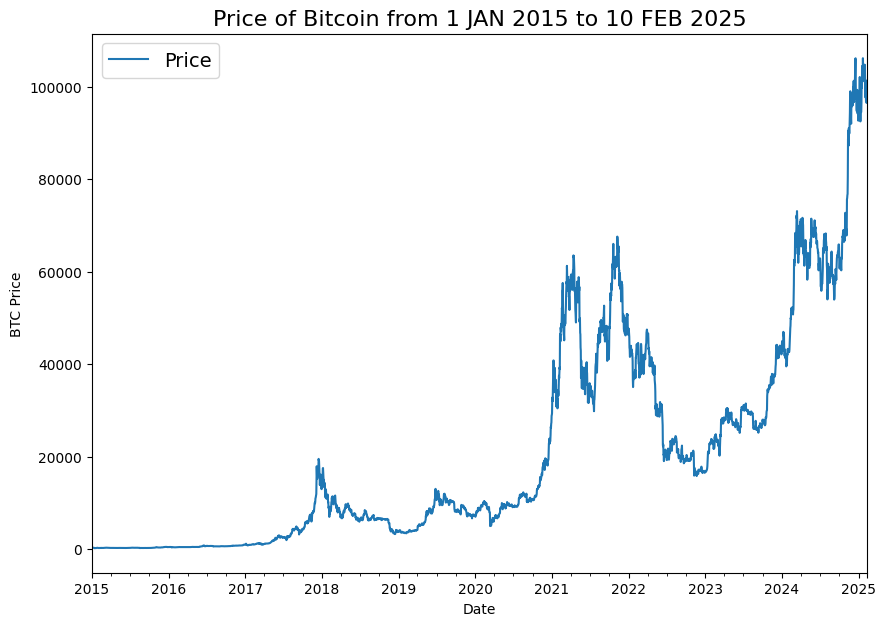

In [55]:
import matplotlib.pyplot as plt
bitcoin_prices_latest.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 JAN 2015 to 10 FEB 2025", fontsize=16)
plt.legend(fontsize=14);

In [56]:
# Get bitcoin date array
timesteps = bitcoin_prices_latest.index.to_numpy()
prices = bitcoin_prices_latest["Price"].to_numpy()

timesteps[:10], prices[:10]

(array([Timestamp('2015-01-01 00:00:00+0000', tz='UTC'),
        Timestamp('2015-01-02 00:00:00+0000', tz='UTC'),
        Timestamp('2015-01-03 00:00:00+0000', tz='UTC'),
        Timestamp('2015-01-04 00:00:00+0000', tz='UTC'),
        Timestamp('2015-01-05 00:00:00+0000', tz='UTC'),
        Timestamp('2015-01-06 00:00:00+0000', tz='UTC'),
        Timestamp('2015-01-07 00:00:00+0000', tz='UTC'),
        Timestamp('2015-01-08 00:00:00+0000', tz='UTC'),
        Timestamp('2015-01-09 00:00:00+0000', tz='UTC'),
        Timestamp('2015-01-10 00:00:00+0000', tz='UTC')], dtype=object),
 array([314.24899292, 315.03201294, 281.08200073, 264.19500732,
        274.47399902, 286.18899536, 294.33700562, 283.34899902,
        290.4079895 , 274.79598999]))

### Creating train and test sets for time series (Latest Dataset)

In [57]:
# Create train and test splits the right way for the time series data
split_size = int(0.8 * len(prices)) # 80% train and 20% test

# Create train data splits
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2954, 739, 2954, 739)

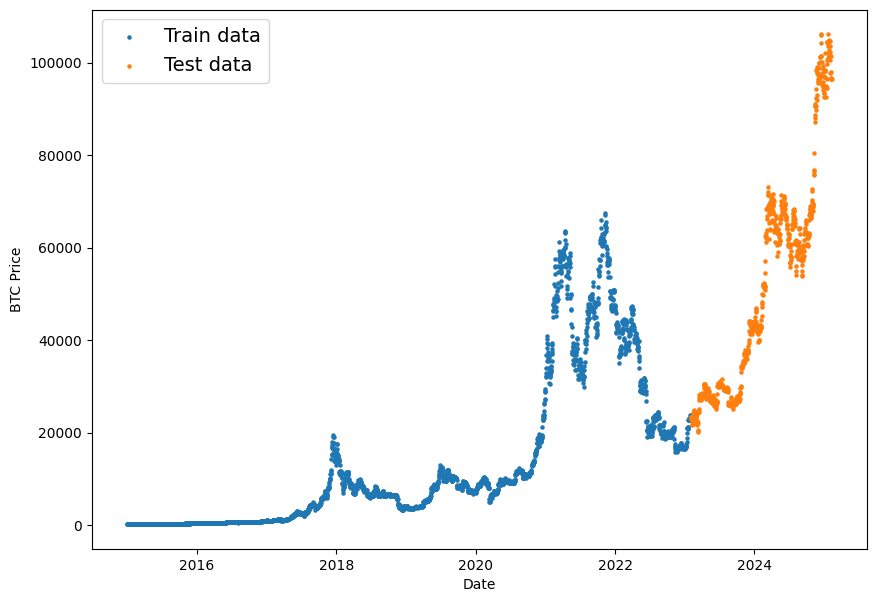

In [58]:
# Plot correctly made splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

In [59]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction

In [60]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [61]:
import numpy as np

def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array into a 2D array of sequential labelled windows of window_size horizon size labels
    """
    # 1. Create a window of specific window_size (Add the horizon on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    #print(f"Window indexes:\n {window_indexes, window_indexes.shape}")

    # 3. Index on the target array (a time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]
    # print(windowed_array[0])

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon)
    return windows, labels

In [62]:
full_windows, full_labels =  make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

In [63]:
len(full_windows), len(full_labels)

(3686, 3686)

### Turning windows into training and test sets

In [64]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2948, 738, 2948, 738)

In [65]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as  reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(HORIZON, activation="linear") # Linear activation is the same as having no activation
], name="model_1_dense_latest_data") # Name of our model so we can save it

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=200,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

In [66]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels) # Last epoch performance

24/24 [==============================] - 0s 2ms/step - loss: 1580.3627 - mae: 1580.3627 - mse: 4478487.0000


[1580.3626708984375, 1580.3626708984375, 4478487.0]

In [67]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("/content/model_experiments/model_1_dense_latest_data.keras")
model_1.evaluate(test_windows, test_labels)

24/24 [==============================] - 0s 2ms/step - loss: 947.9305 - mae: 947.9305 - mse: 2189289.0000


[947.9305419921875, 947.9305419921875, 2189289.0]

In [68]:
def make_preds(model, input_data):
    """
    Uses model to make predictions input_data
    """
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # Return 1D array of predictions

In [69]:
# Make predictions using loaded_model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

24/24 [==============================] - 0s 2ms/step


(738,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([23463.729, 23487.775, 23318.965, 22968.387, 22785.242, 23208.521,
        22964.713, 21917.266, 21659.594, 21821.11 ], dtype=float32)>)

In [70]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 947.93054,
 'mse': 2189289.0,
 'rmse': 1479.6246,
 'mape': 1.7580181,
 'mase': 0.99295706}

## 3. For most of our models we used WINDOW_SIZE=7, but is there a better window size?
  * Setup a series of experiments to find whether or not there’s a better window size.
  * For example, you might train 10 different models with HORIZON=1 but with window sizes ranging from 2-12.

In [71]:
model_results = []

from tqdm import tqdm

for size in tqdm(range(2, 12)):
  HORIZON = 1
  WINDOW_SIZE = size


  full_windows, full_labels =  make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

  # Create train and test windows
  train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

  # Building a simple dense model
  input = layers.Input(shape = (WINDOW_SIZE ,) , name = 'Input_layer' , dtype = tf.float32)
  x = layers.Dense(256 , activation= 'relu')(input)
  output = layers.Dense(HORIZON , activation= 'linear')(x)

  # Packing into a model
  model = tf.keras.Model(input , output)

  # Compiling the model
  model.compile(loss = 'mae' ,
                  optimizer = tf.keras.optimizers.Adam() ,
                  metrics = ['mae'])

  # Fit the model
  model.fit(x=train_windows,
              y=train_labels,
              epochs = 100, verbose = 0,
              batch_size=128,
              validation_data = (test_windows, test_labels))

  model_preds = make_preds(model, test_windows)

  # Evaluate preds
  results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                  y_pred=model_preds)

  model_results.append(results)


  0%|          | 0/10 [00:00<?, ?it/s]

24/24 [==============================] - 0s 1ms/step


 10%|█         | 1/10 [00:11<01:39, 11.07s/it]

24/24 [==============================] - 0s 1ms/step


 20%|██        | 2/10 [00:19<01:16,  9.51s/it]

24/24 [==============================] - 0s 2ms/step


 30%|███       | 3/10 [00:28<01:03,  9.07s/it]

24/24 [==============================] - 0s 1ms/step


 40%|████      | 4/10 [00:35<00:51,  8.61s/it]

24/24 [==============================] - 0s 1ms/step


 50%|█████     | 5/10 [00:44<00:42,  8.53s/it]

24/24 [==============================] - 0s 1ms/step


 60%|██████    | 6/10 [00:55<00:37,  9.47s/it]

24/24 [==============================] - 0s 1ms/step


 70%|███████   | 7/10 [01:06<00:29,  9.95s/it]

24/24 [==============================] - 0s 1ms/step


 80%|████████  | 8/10 [01:14<00:18,  9.32s/it]

24/24 [==============================] - 0s 1ms/step


 90%|█████████ | 9/10 [01:22<00:09,  9.03s/it]

24/24 [==============================] - 0s 1ms/step


100%|██████████| 10/10 [01:31<00:00,  9.14s/it]


In [72]:
model_results

[{'mae': 948.92865,
  'mse': 2173489.2,
  'rmse': 1474.2759,
  'mape': 1.7641829,
  'mase': 0.99531937},
 {'mae': 1006.9119,
  'mse': 2370047.8,
  'rmse': 1539.496,
  'mape': 1.8698212,
  'mase': 1.0547401},
 {'mae': 1034.8782,
  'mse': 2458525.2,
  'rmse': 1567.9685,
  'mape': 1.9293225,
  'mase': 1.0840347},
 {'mae': 970.7787,
  'mse': 2260666.2,
  'rmse': 1503.5513,
  'mape': 1.7981542,
  'mase': 1.0168905},
 {'mae': 1368.5559,
  'mse': 3462898.8,
  'rmse': 1860.8866,
  'mape': 2.646101,
  'mase': 1.433562},
 {'mae': 1219.5813,
  'mse': 3067089.5,
  'rmse': 1751.3108,
  'mape': 2.3054445,
  'mase': 1.2775111},
 {'mae': 968.0359,
  'mse': 2264569.0,
  'rmse': 1504.8485,
  'mape': 1.7900953,
  'mase': 1.0128106},
 {'mae': 1740.6284,
  'mse': 5113482.0,
  'rmse': 2261.301,
  'mape': 3.4018018,
  'mase': 1.821138},
 {'mae': 1078.5449,
  'mse': 2519151.5,
  'rmse': 1587.1835,
  'mape': 2.045215,
  'mase': 1.1284311},
 {'mae': 1173.9491,
  'mse': 2856062.5,
  'rmse': 1689.9889,
  'mape': 

## 4. Create a windowed dataset just like the ones we used for model_1 using `tf.keras.preprocessing.timeseries_dataset_from_array()` and retrain `model_1` using the recreated dataset.

In [73]:
WINDOW_SIZE = 7
HORIZON = 1

In [74]:
dataset = tf.keras.preprocessing.timeseries_dataset_from_array(data = prices,
    targets = prices,
    sequence_length = WINDOW_SIZE,
    sequence_stride = HORIZON, batch_size = 128
)

In [75]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [76]:
train_size, test_size = int(0.8 * len(dataset)), int(0.2 * len(dataset))
train_size, test_size

(23, 5)

In [77]:
23 * 128, 128 * 5

(2944, 640)

In [78]:
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size).take(test_size)

In [79]:
# View the first 3 windows/labels
for x, y in train_ds.take(1):
  print(x[:3], y[:3])

tf.Tensor(
[[314.24899292 315.03201294 281.08200073 264.19500732 274.47399902
  286.18899536 294.33700562]
 [315.03201294 281.08200073 264.19500732 274.47399902 286.18899536
  294.33700562 283.34899902]
 [281.08200073 264.19500732 274.47399902 286.18899536 294.33700562
  283.34899902 290.4079895 ]], shape=(3, 7), dtype=float64) tf.Tensor([314.24899292 315.03201294 281.08200073], shape=(3,), dtype=float64)


In [80]:
# Splitting train data and labels
X_train = []
y_train = []
for x, y in train_ds:
  X_train.append(x)
  y_train.append(y)

X_test = []
y_test = []
for x, y in test_ds:
  X_test.append(x)
  y_test.append(y)

In [81]:

tf.random.set_seed(42)

# Building a simple dense model
input = layers.Input(shape = (WINDOW_SIZE ,) , name = 'Input_layer' , dtype = tf.float32)
x = layers.Dense(256 , activation= 'relu')(input)
output = layers.Dense(HORIZON , activation= 'linear')(x)

# Packing into a model
model_1 = tf.keras.Model(input , output)

# Compiling the model
model_1.compile(loss = 'mae' ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ['mae'])

# Fit the model
model_1.fit(train_ds,
            epochs = 100, verbose = 0,
            validation_data = test_ds)

In [82]:
model_preds = tf.squeeze(model_1.predict(test_ds))
model_preds[:10]

5/5 [==============================] - 0s 14ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([23342.62 , 23093.207, 23569.139, 23419.424, 23536.252, 23540.875,
       24090.467, 23305.896, 23622.06 , 24127.521], dtype=float32)>

In [83]:
model_1.evaluate(test_ds)

5/5 [==============================] - 0s 14ms/step - loss: 820.6874 - mae: 820.6874


[820.6873779296875, 820.6873779296875]

## 5. For our multivariate modelling experiment, we added the Bitcoin block reward size as an extra feature to make our time series multivariate.
  * Are there any other features you think you could add?
  * If so, try it out, how do these affect the model?

In [84]:
df_latest.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-01 00:00:00+00:00,320.434998,320.434998,314.002991,314.248993,8036550,0.0,0.0
2015-01-02 00:00:00+00:00,314.079010,315.838989,313.565002,315.032013,7860650,0.0,0.0
2015-01-03 00:00:00+00:00,314.846008,315.149994,281.082001,281.082001,33054400,0.0,0.0
2015-01-04 00:00:00+00:00,281.145996,287.230011,257.612000,264.195007,55629100,0.0,0.0
2015-01-05 00:00:00+00:00,265.084015,278.341003,265.084015,274.473999,43962800,0.0,0.0


> Volume – It represents the number of trades or transactions, which can indicate market interest and liquidity.

In [85]:
# Only want closing price for each day
bitcoin_prices_df = pd.DataFrame(df_latest[["Close", "Volume"]]).rename(columns={"Close": "Price", "Volume": "volume"})
# bitcoin_prices_df = pd.DataFrame(df_latest["Close"]).rename(columns={"Close": "Price"})
bitcoin_prices_df.head()

,Price,volume
Date,,
2015-01-01 00:00:00+00:00,314.248993,8036550
2015-01-02 00:00:00+00:00,315.032013,7860650
2015-01-03 00:00:00+00:00,281.082001,33054400
2015-01-04 00:00:00+00:00,264.195007,55629100
2015-01-05 00:00:00+00:00,274.473999,43962800


In [86]:
# Adding a day of week column
import datetime
df_latest["day_of_week"] = df_latest.index.dayofweek

In [87]:
df_latest.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,day_of_week
Date,,,,,,,,
2015-01-01 00:00:00+00:00,320.434998,320.434998,314.002991,314.248993,8036550,0.0,0.0,3
2015-01-02 00:00:00+00:00,314.079010,315.838989,313.565002,315.032013,7860650,0.0,0.0,4
2015-01-03 00:00:00+00:00,314.846008,315.149994,281.082001,281.082001,33054400,0.0,0.0,5
2015-01-04 00:00:00+00:00,281.145996,287.230011,257.612000,264.195007,55629100,0.0,0.0,6
2015-01-05 00:00:00+00:00,265.084015,278.341003,265.084015,274.473999,43962800,0.0,0.0,0
2015-01-06 00:00:00+00:00,274.610992,287.553009,272.696014,286.188995,23245700,0.0,0.0,1
2015-01-07 00:00:00+00:00,286.076996,298.753998,283.079010,294.337006,24866800,0.0,0.0,2
2015-01-08 00:00:00+00:00,294.135010,294.135010,282.174988,283.348999,19982500,0.0,0.0,3
2015-01-09 00:00:00+00:00,282.382996,291.114014,280.532990,290.407990,18718600,0.0,0.0,4


In [88]:
bitcoin_prices_df['day_of_week'] = bitcoin_prices_df.index.dayofweek

In [89]:
bitcoin_prices_df.head(10)

,Price,volume,day_of_week
Date,,,
2015-01-01 00:00:00+00:00,314.248993,8036550,3
2015-01-02 00:00:00+00:00,315.032013,7860650,4
2015-01-03 00:00:00+00:00,281.082001,33054400,5
2015-01-04 00:00:00+00:00,264.195007,55629100,6
2015-01-05 00:00:00+00:00,274.473999,43962800,0
2015-01-06 00:00:00+00:00,286.188995,23245700,1
2015-01-07 00:00:00+00:00,294.337006,24866800,2
2015-01-08 00:00:00+00:00,283.348999,19982500,3
2015-01-09 00:00:00+00:00,290.407990,18718600,4


In [90]:
scaler = MinMaxScaler()

In [91]:
bitcoin_prices_df["volume"] = scaler.fit_transform(bitcoin_prices_df[["volume"]])

In [92]:
bitcoin_prices_df.head()

,Price,volume,day_of_week
Date,,,
2015-01-01 00:00:00+00:00,314.248993,5.011966e-07,3
2015-01-02 00:00:00+00:00,315.032013,0.000000e+00,4
2015-01-03 00:00:00+00:00,281.082001,7.178523e-05,5
2015-01-04 00:00:00+00:00,264.195007,1.361079e-04,6
2015-01-05 00:00:00+00:00,274.473999,1.028668e-04,0


In [93]:
bitcoin_prices_df.columns

Index(['Price', 'volume', 'day_of_week'], dtype='object')

<Axes: xlabel='Date'>

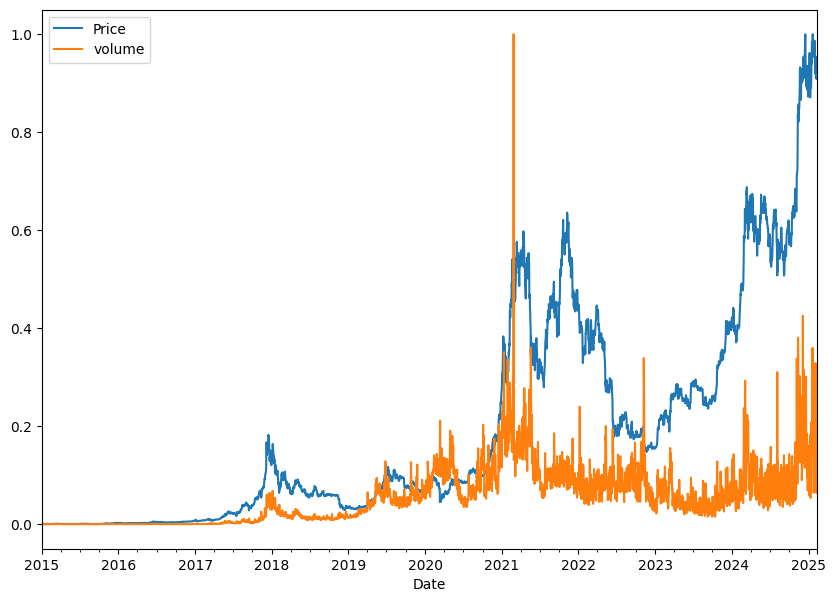

In [94]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_df[["Price", "volume"]]),
                                     columns=['Price', 'volume'],
                                     index=bitcoin_prices_df.index)
scaled_price_block_df.plot(figsize=(10, 7))

In [95]:
# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_df[f"Price+{i+1}"] = bitcoin_prices_df["Price"].shift(periods=i+1)
bitcoin_prices_df.head(10)

,Price,volume,day_of_week,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,
2015-01-01 00:00:00+00:00,314.248993,5.011966e-07,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02 00:00:00+00:00,315.032013,0.000000e+00,4,314.248993,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03 00:00:00+00:00,281.082001,7.178523e-05,5,315.032013,314.248993,NaN,NaN,NaN,NaN,NaN
2015-01-04 00:00:00+00:00,264.195007,1.361079e-04,6,281.082001,315.032013,314.248993,NaN,NaN,NaN,NaN
2015-01-05 00:00:00+00:00,274.473999,1.028668e-04,0,264.195007,281.082001,315.032013,314.248993,NaN,NaN,NaN
2015-01-06 00:00:00+00:00,286.188995,4.383704e-05,1,274.473999,264.195007,281.082001,315.032013,314.248993,NaN,NaN
2015-01-07 00:00:00+00:00,294.337006,4.845608e-05,2,286.188995,274.473999,264.195007,281.082001,315.032013,314.248993,NaN
2015-01-08 00:00:00+00:00,283.348999,3.453911e-05,3,294.337006,286.188995,274.473999,264.195007,281.082001,315.032013,314.248993
2015-01-09 00:00:00+00:00,290.407990,3.093785e-05,4,283.348999,294.337006,286.188995,274.473999,264.195007,281.082001,315.032013


In [96]:
# Create X (windows) and y (horizons) features
X = bitcoin_prices_df.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_df.dropna()["Price"].astype(np.float32)
X.head()

,volume,day_of_week,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2015-01-08 00:00:00+00:00,0.000035,3.0,294.337006,286.188995,274.473999,264.195007,281.082001,315.032013,314.248993
2015-01-09 00:00:00+00:00,0.000031,4.0,283.348999,294.337006,286.188995,274.473999,264.195007,281.082001,315.032013
2015-01-10 00:00:00+00:00,0.000021,5.0,290.407990,283.348999,294.337006,286.188995,274.473999,264.195007,281.082001
2015-01-11 00:00:00+00:00,0.000029,6.0,274.795990,290.407990,283.348999,294.337006,286.188995,274.473999,264.195007
2015-01-12 00:00:00+00:00,0.000031,0.0,265.660004,274.795990,290.407990,283.348999,294.337006,286.188995,274.473999


In [97]:
y.head()

,Price
Date,
2015-01-08 00:00:00+00:00,283.348999
2015-01-09 00:00:00+00:00,290.407990
2015-01-10 00:00:00+00:00,274.795990
2015-01-11 00:00:00+00:00,265.660004
2015-01-12 00:00:00+00:00,267.795990


In [98]:
len(X), len(y)

(3686, 3686)

In [99]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2948, 2948, 738, 738)

### Model 6: Dense (multivariate time series)

In [100]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(512, activation="relu"),
  layers.Dense(512, activation="relu"),
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=200,
            batch_size=64,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [101]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

24/24 [==============================] - 0s 2ms/step - loss: 1779.0389


1779.0389404296875

In [102]:
# Load in and evaluate best performing model
model_6 = tf.keras.models.load_model("/content/model_experiments/model_6_dense_multivariate.keras")
model_6.evaluate(X_test, y_test)

24/24 [==============================] - 0s 2ms/step - loss: 949.7330


949.7329711914062

In [103]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

24/24 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([23487.143, 23492.432, 23353.219, 22997.316, 22793.938, 23209.883,
       22967.184, 21971.867, 21699.75 , 21823.797], dtype=float32)>

In [104]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 949.7328,
 'mse': 2190304.5,
 'rmse': 1479.9678,
 'mape': 1.7627362,
 'mase': 0.9948449}

## 6. Make prediction intervals for future forecasts. To do so, one way would be to train an ensemble model on all of the data, make future forecasts with it and calculate the prediction intervals of the ensemble just like we did for model_8.

In [105]:
# Make our whole dataset (With the updated bitcoin price 2015 - 2025)
start_date = "2015-01-01"
end_date = "2025-02-10"

In [106]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [107]:
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

len(X_all), len(y_all)

(2780, 2780)

In [108]:
bitcoin_prices_df.count()

,0
Price,3693
volume,3693
day_of_week,3693
Price+1,3692
Price+2,3691
Price+3,3690
Price+4,3689
Price+5,3688
Price+6,3687
Price+7,3686


In [109]:
# Turn data into efficient running tensors

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimial performance
BATCH_SIZE = 128
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [110]:
def get_ensemble_models(horizon=HORIZON,
                        dataset=dataset_all,
                        num_iter=10, # How many different models we are going to train
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]):


  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          # Initialize dense layers with normal distribution for estimating prediction intervals later on
          # Each models going to be initialized with 'he_normal' distributions
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit the current model
      model.fit(dataset_all,
                epochs=num_epochs,
                verbose=0,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",
                                                                patience=100,
                                                                verbose=1)])

      # Append fitted model to list of emsemble models
      ensemble_models.append(model)

  return ensemble_models

In [111]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 275: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 434: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 201: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 489: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 255: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 357: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 458: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 204: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 335: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing 

### Make predictions into future

To make predictions into the future we want a function which:

1. Takes as input:

* a list of values (Bitcoin historical data)

* a trained model (such as `model_9`)

* a window into the future to predict (our `INTO_FUTURE` variable)

* the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on

2. Creates an empty list for future forecasts (this will be returned at the end of the end, when it's full of predictions) and extracts the last `WINDOW_SIZE` values from the input values

3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the latest prediction

In [112]:
# How many timestesp to predict into the future?
INTO_FUTURE = 14

In [113]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model_list, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after values ends.

  Returns future forecasts as a list of floats.
  """
  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE numer of predictions, altering the data which gets predicted on each
  for _ in range(INTO_FUTURE):
    for model in model_list:
      # Predict on the last window then append it again, again, again (our model will eventually start to make forecasts on its own forecasts)
      future_pred = model.predict(tf.expand_dims(last_window, axis=0))
      print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

      # Append predictions to future_forecast
      future_forecast.append(tf.squeeze(future_pred).numpy())

      # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
      last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [114]:
# Make forecasts into the future
future_forecast = make_future_forecasts(values=y_all,
                                        model_list=ensemble_models,
                                        into_future=INTO_FUTURE,
                                        window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 47ms/step
Predicting on:
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 56460.71484375

1/1 [==============================] - 0s 46ms/step
Predicting on:
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 56460.71484375] -> Prediction: 51194.5703125

1/1 [==============================] - 0s 49ms/step
Predicting on:
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 56460.71484375 51194.5703125 ] -> Prediction: 49942.1953125



1/1 [==============================] - 0s 45ms/step
Predicting on:
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 56460.71484375 51194.5703125  49942.1953125 ] -> Prediction: 49673.04296875



1/1 [==============================] - 0s 46ms/step
Predicting on:
 [47885.62525472 45604.61575361 43144.47129086 56460.71484375
 51194.5703125  49942.1953125  49673.04296875] -> Prediction: 47968.60546875

1/1 [==============================] - 0s 62ms/step
Predicting on:
 [45604.61575361 43144.47129086 56460.71484375 51194.5703125
 49942.1953125  49673.04296875 47968.60546875] -> Prediction: 47081.734375

1/1 [==============================] - 0s 53ms/step
Predicting on:
 [43144.47129086 56460.71484375 51194.5703125  49942.1953125
 49673.04296875 47968.60546875 47081.734375  ] -> Prediction: 46760.70703125

1/1 [==============================] - 0s 46ms/step
Predicting on:
 [56460.71484375 51194.5703125  49942.1953125  49673.04296875
 47968.60546875 47081.734375   46760.70703125] -> Prediction: 56272.61328125

1/1 [==============================] - 0s 51ms/step
Predicting on:
 [51194.5703125  49942.1953125  49673.04296875 47968.60546875
 47081.734375   46760.70703125 56272.61328125] 

## 7. For future predictions, try to make a prediction, retrain a model on the predictions, make a prediction, retrain a model, make a prediction, retrain a model, make a prediction (retrain a model each time a new prediction is made). Plot the results, how do they look compared to the future predictions where a model wasn’t retrained for every forecast (model_9)?

In [115]:
# 1. Create function to make predictions into the future
def model_future_forecasts(X, values, model, into_future, window_size=WINDOW_SIZE, horizon = HORIZON, epochs = 10):
  """
  This function train a model for every updated predictions.
  """
  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]
  X_all = X
  y_all = values

  # 3. Make INTO_FUTURE numer of predictions, altering the data which gets predicted on each
  for _ in range(INTO_FUTURE):


    # Each time model is trained for 5 epochs with the updated data
    model.fit(x = X_all, y = y_all, epochs = epochs, verbose = 0)

    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    for i in range(len(X_all)):
      x = X_all[i][1:]
      y = y_all[1:]
      X = np.append(x, future_pred)
      values = np.append(y, future_pred)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return model

In [116]:
X_all = bitcoin_prices_df.dropna().drop(["Price", "day_of_week", "volume"], axis=1).to_numpy()
# Get labels
y_all = bitcoin_prices_df.dropna()["Price"].to_numpy()

len(X_all), len(y_all)

(3686, 3686)

In [117]:
X_all.shape, y_all.shape

((3686, 7), (3686,))

In [118]:
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(HORIZON, activation="linear") # Linear activation is the same as having no activation
], name="model_1_dense") # Name of our model so we can save it

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

In [119]:
# Using the above function
trained_model = model_future_forecasts(X = X_all, values = y_all,
                               model = model_1,
                               into_future = 14,
                               window_size = WINDOW_SIZE,
                               horizon = HORIZON,
                               epochs = 10)

1/1 [==============================] - 0s 52ms/step
Predicting on:
 [101405.421875   97871.8203125  96615.4453125  96593.296875
  96529.0859375  96482.453125   96500.09375  ] -> Prediction: 99236.140625

1/1 [==============================] - 0s 19ms/step
Predicting on:
 [97871.8203125 96615.4453125 96593.296875  96529.0859375 96482.453125
 96500.09375   99236.140625 ] -> Prediction: 98933.2265625

1/1 [==============================] - 0s 17ms/step
Predicting on:
 [96615.4453125 96593.296875  96529.0859375 96482.453125  96500.09375
 99236.140625  98933.2265625] -> Prediction: 96035.7109375

1/1 [==============================] - 0s 16ms/step
Predicting on:
 [96593.296875  96529.0859375 96482.453125  96500.09375   99236.140625
 98933.2265625 96035.7109375] -> Prediction: 91569.46875

1/1 [==============================] - 0s 18ms/step
Predicting on:
 [96529.0859375 96482.453125  96500.09375   99236.140625  98933.2265625
 96035.7109375 91569.46875  ] -> Prediction: 95736.734375

1/1 [==